# Imports

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch_geometric
from torch_geometric.data import Data
from scipy.spatial.distance import cdist
import pickle
import rasterio
import glob
import tifffile
import matplotlib.pyplot as plt
import re

# ______________________

# Healthy

## Pre-Process

### Create RGB Images

In [3]:
date_folders = sorted(glob.glob(os.path.join(lord_2_path, '*')))

for date_folder in date_folders:
    if os.path.isdir(date_folder):
        color_folders = [os.path.join(date_folder, color) for color in ['Red', 'Green', 'Blue']]
        rgb_folder = os.path.join(date_folder, 'RGB')
        os.makedirs(rgb_folder, exist_ok=True)


        tif_files = glob.glob(os.path.join(color_folders[0], '*.tif'))

        for tif_file in tif_files:
            filename = os.path.basename(tif_file)
            red_image = tifffile.imread(os.path.join(color_folders[0], filename))
            green_image = tifffile.imread(os.path.join(color_folders[1], filename))
            blue_image = tifffile.imread(os.path.join(color_folders[2], filename))

            rgb_image = np.dstack((red_image, green_image, blue_image))
            rgb_file_path = os.path.join(rgb_folder, filename)
            tifffile.imsave(rgb_file_path, rgb_image)

/var/folders/_d/jhdpffbd49j0l469jld4vbfc0000gn/T/ipykernel_9636/2468088315.py:20: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(rgb_file_path, rgb_image)


### Convert to 16bit

In [23]:
output_dir = 'Test Stitch/16bit/'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir('Test Stitch'):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        image_path = os.path.join('Test Stitch', filename)
        
        # Read the TIFF image using tifffile
        image = tifffile.imread(image_path)
        
        # Print the dtype and determine the bit depth
        image_array = np.array(image)
        dtype = image_array.dtype
        print(f"Processing {filename}")
        print(f"Image dtype: {dtype}")
        
        # Determine bit depth
        if dtype == np.uint8:
            bit_depth = 8
        elif dtype == np.uint16:
            bit_depth = 16
        elif dtype == np.float32:
            bit_depth = 32
        elif dtype == np.float64:
            bit_depth = 64
        else:
            bit_depth = "Unknown"
        
        print(f"Image bit depth: {bit_depth}")
        
        if bit_depth != 16:
            max_val = np.max(image_array)
            if max_val == 0:
                print(f"Warning: {filename} contains only zero values. Skipping normalization.")
                image_16bit_array = np.zeros_like(image_array, dtype=np.uint16)
            else:
                image_16bit_array = (image_array / max_val * 65535).astype(np.uint16)
        else:
            image_16bit_array = image_array

        print(image_16bit_array.dtype)

        
        output_filename = os.path.splitext(filename)[0] + '_16bit.tif'
        output_path = os.path.join(output_dir, output_filename)
        tifffile.imwrite(output_path, image_16bit_array)
        
        print(f"Saved 16-bit image to {output_path}")


# for filename in os.listdir('Healthy2/LORD-2/2017-02-23/Red/original'):
#     if filename.endswith('.tif') or filename.endswith('.tiff'):
#         image_path = os.path.join('Healthy2/LORD-2/2017-02-23/Red/original' + '/', filename)
#         image = Image.open(image_path)

#         mode = image.mode
#         print(f"Image mode: {mode}")

#         image_array = np.array(image)

#         dtype = image_array.dtype
#         print(f"Image dtype: {dtype}")

#         if dtype == np.uint8:
#             bit_depth = 8
#         elif dtype == np.uint16:
#             bit_depth = 16
#         elif dtype == np.float32:
#             bit_depth = 32
#         elif dtype == np.float64:
#             bit_depth = 64
#         else:
#             bit_depth = "Unknown"

#         print(f"Image bit depth: {bit_depth}")

#         image_32bit = Image.open(image_path)
#         image_array = np.array(image_32bit)
#         image_16bit_array = (image_array / np.max(image_array) * 65535).astype(np.uint16)
#         image_16bit = Image.fromarray(image_16bit_array)

#         output_filename = os.path.splitext(filename)[0] + '.tif'
#         output_path = os.path.join('Healthy2/LORD-2/2017-02-23/Red/16bit/', output_filename)
#         image_16bit.save(output_path)

Processing AMD1_Clone-A_D75_n990_r179_c13.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n990_r179_c13_16bit.tif
Processing AMD1_Clone-A_D75_n993_r179_c613.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n993_r179_c613_16bit.tif
Processing AMD1_Clone-A_D75_n991_r179_c213.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n991_r179_c213_16bit.tif
Processing AMD1_Clone-A_D75_n992_r179_c413.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n992_r179_c413_16bit.tif
Processing AMD1_Clone-A_D75_n994_r179_c813.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n994_r179_c813_16bit.tif
Processing AMD1_Clone-A_D75_n995_r179_c1013.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to

### 16bit Sanity Check

In [123]:
image_path = 'AMD/Abs Images 16bit/1A_D75_n990.tif'
image = tifffile.imread(image_path)

image_array = np.array(image)

dtype = image_array.dtype
print(f"Image dtype: {dtype}")

if dtype == np.uint8:
    bit_depth = 8
elif dtype == np.uint16:
    bit_depth = 16
elif dtype == np.float32:
    bit_depth = 32
elif dtype == np.float64:
    bit_depth = 64
else:
    bit_depth = "Unknown"

print(f"Image bit depth: {bit_depth}")

# image_path = 'Test Stitch/16bit/AMD1_Clone-A_D75_n990_r179_c13_16bit.tif'
# image = Image.open(image_path)

# mode = image.mode
# print(f"Image mode: {mode}")

# image_array = np.array(image)

# dtype = image_array.dtype
# print(f"Image dtype: {dtype}")

# if dtype == np.uint8:
#     bit_depth = 8
# elif dtype == np.uint16:
#     bit_depth = 16
# elif dtype == np.float32:
#     bit_depth = 32
# elif dtype == np.float64:
#     bit_depth = 64
# else:
#     bit_depth = "Unknown"

# print(f"Image bit depth: {bit_depth}")

Image dtype: uint16
Image bit depth: 16


## Analyze CSV

In [12]:
import csv
from statistics import mean, median, stdev

for filename in os.listdir('Healthy2/LORD-2/2017-03-02/Red/cleaned_CSVs'):
    if filename.endswith('.csv'):
        with open('Healthy2/LORD-2/2017-03-02/Red/cleaned_CSVs/'+filename, 'r') as file:
            reader = csv.DictReader(file)    
            area_values = []
            
            for row in reader:
                area_value = float(row['Area'])
                area_values.append(area_value)

            npArea = np.array(area_values)

            avg_area = mean(area_values)
            median_area = median(area_values)
            min_area = min(area_values)
            max_area = max(area_values)
            std_dev_area = stdev(area_values)

            quantiles = np.linspace(0, 1, 9)
            quantile_values = np.quantile(npArea, quantiles)

            print(f"Average of 'Area' column: {avg_area}")
            print(f"Median of 'Area' column: {median_area}")
            print(f"Minimum value in 'Area' column: {min_area}")
            print(f"Maximum value in 'Area' column: {max_area}")
            print(f"Standard deviation of 'Area' column: {std_dev_area}")
            print("q1:", quantile_values[0],
                "q2:", quantile_values[1],
                "q3:", quantile_values[2],
                "q4:", quantile_values[3],
                "q5:", quantile_values[4],
                "q6:", quantile_values[5],
                "q7:", quantile_values[6],
                "q8:", quantile_values[7],
                "q9:", quantile_values[8])


Average of 'Area' column: 118.85317164179105
Median of 'Area' column: 97.0
Minimum value in 'Area' column: 51.0
Maximum value in 'Area' column: 299.0
Standard deviation of 'Area' column: 63.22158735203867
q1: 51.0 q2: 58.0 q3: 68.0 q4: 79.625 q5: 97.0 q6: 121.0 q7: 156.0 q8: 208.0 q9: 299.0
Average of 'Area' column: 117.37497746529655
Median of 'Area' column: 94.0
Minimum value in 'Area' column: 51.0
Maximum value in 'Area' column: 299.0
Standard deviation of 'Area' column: 63.59087878149997
q1: 51.0 q2: 57.0 q3: 67.0 q4: 79.0 q5: 94.0 q6: 117.0 q7: 151.0 q8: 208.0 q9: 299.0
Average of 'Area' column: 112.76431174327024
Median of 'Area' column: 88.0
Minimum value in 'Area' column: 51.0
Maximum value in 'Area' column: 299.0
Standard deviation of 'Area' column: 62.165340511441826
q1: 51.0 q2: 57.0 q3: 65.0 q4: 75.0 q5: 88.0 q6: 110.0 q7: 144.0 q8: 199.0 q9: 299.0
Average of 'Area' column: 119.9970631424376
Median of 'Area' column: 97.0
Minimum value in 'Area' column: 51.0
Maximum value in

## Data Gen

### Remove NaN from csv

In [13]:
for filename in os.listdir('Healthy2/LORD-2/2017-02-23/Red/CSVs'):
    if filename.endswith('.csv'):
        
        df = pd.read_csv('Healthy2/LORD-2/2017-02-23/Red/CSVs/'+filename)
        before = len(df)
        print("Length Before: ", before)

        df_cleaned = df.dropna()
        df_cleaned = df_cleaned[df_cleaned['Area'] < 300]  
        df_cleaned = df_cleaned[df_cleaned['Area'] > 50]  
        df_cleaned.to_csv('Healthy2/LORD-2/2017-02-23/Red/cleaned_CSVs/'+filename, index=False)

        after = len(df_cleaned)
        print("Length After: ", after)


        print(f"Removed {before - after} from {filename} Rows with NaN or outlier values.")

Length Before:  24951
Length After:  5571
Removed 19380 from B2-R.csv Rows with NaN or outlier values.
Length Before:  25095
Length After:  5636
Removed 19459 from B1-R.csv Rows with NaN or outlier values.
Length Before:  23646
Length After:  4974
Removed 18672 from C4-R.csv Rows with NaN or outlier values.
Length Before:  21384
Length After:  4980
Removed 16404 from C2-R.csv Rows with NaN or outlier values.
Length Before:  22210
Length After:  4919
Removed 17291 from C3-R.csv Rows with NaN or outlier values.
Length Before:  21261
Length After:  4387
Removed 16874 from C1-R.csv Rows with NaN or outlier values.


### Get Features Array

In [3]:
def get_features(centroid_data):

    features = centroid_data[['Area', 'Aspect_Ratio_BB', 'BB_Xmin', 'BB_Ymin', 'BB_Width', 'BB_Height', 
                              'Center_BB_X', 'Center_BB_Y', 'Centroid_X', 'Centroid_Y', 'Circularity', 
                              'Distance_From_Border', 'Eccentricity', 'Entropy', 'ExtendBB', 'Mean', 
                              'Median', 'Mode', 'Orientation', 'Perimeter', 'StandardDeviation', 
                              'Skewness', 'Kurtosis', 'Hyperskewness', 'Hyperflatness', 'TContrast_Average', 
                              'TContrast_Ortho_principal_component_value', 'TContrast_Principal_component_angle', 
                              'TContrast_Principal_component_value', 'TCorrelation_Average', 
                              'TCorrelation_Ortho_principal_component_value', 'TCorrelation_Principal_component_angle', 
                              'TCorrelation_Principal_component_value', 'THomogeneity_Average', 
                              'THomogeneity_Ortho_principal_component_value', 'THomogeneity_Principal_component_angle', 
                              'THomogeneity_Principal_component_value', 'TEnergy_Average', 
                              'TEnergy_Ortho_principal_component_value', 'TEnergy_Principal_component_angle', 
                              'TEnergy_Principal_component_value', 'TVariance_Average', 
                              'TVariance_Ortho_principal_component_value', 'TVariance_Principal_component_angle', 
                              'TVariance_Principal_component_value', 'TEntropy_Average', 
                              'TEntropy_Ortho_principal_component_value', 'TEntropy_Principal_component_angle', 
                              'TEntropy_Principal_component_value', 'TInvDiffMoment_Average', 
                              'TInvDiffMoment_Ortho_principal_component_value', 'TInvDiffMoment_Principal_component_angle', 
                              'TInvDiffMoment_Principal_component_value', 'TSumAverage_Average', 
                              'TSumAverage_Ortho_principal_component_value', 'TSumAverage_Principal_component_angle', 
                              'TSumAverage_Principal_component_value', 'TSumVariance_Average', 
                              'TSumVariance_Ortho_principal_component_value', 'TSumVariance_Principal_component_angle', 
                              'TSumVariance_Principal_component_value', 'TSumEntropy_Average', 
                              'TSumEntropy_Ortho_principal_component_value', 'TSumEntropy_Principal_component_angle', 
                              'TSumEntropy_Principal_component_value', 'TDiffAverage_Average', 
                              'TDiffAverage_Ortho_principal_component_value', 'TDiffAverage_Principal_component_angle', 
                              'TDiffAverage_Principal_component_value', 'TDiffVariance_Average', 
                              'TDiffVariance_Ortho_principal_component_value', 'TDiffVariance_Principal_component_angle', 
                              'TDiffVariance_Principal_component_value', 'TDiffEntropy_Average', 
                              'TDiffEntropy_Ortho_principal_component_value', 'TDiffEntropy_Principal_component_angle', 
                              'TDiffEntropy_Principal_component_value'

                              ]].values.astype(np.float32)

    return features

### Generate Graphs

In [4]:
df_TER_y = pd.read_csv('Healthy2/EVOM.csv')
df_VEGF_y = pd.read_csv('Healthy2/VEGF.csv')
date_folders = sorted(glob.glob(os.path.join(lord_2_path, '*')))


def extract_well_from_filename(filename):
    basename = os.path.basename(filename)
    parts = basename.split('-')
    well = parts[0] 
    return well

output_filename = 'AbsImage_dataset.pkl'
num_neighbours = 20  # 10 originally

data_list = []

for date_folder in date_folders:
    if os.path.isdir(date_folder):
        if os.path.isdir(date_folder + '/Red/cleaned_CSVs'):
            for file in os.listdir(date_folder + '/Red/cleaned_CSVs'):
                if file.endswith('.csv'):
                    file_path = os.path.join(date_folder + '/Red/cleaned_CSVs' , file)
                    print("Processing file:", file)

                    centroids = pd.read_csv(file_path)

                    well = extract_well_from_filename(file)
                    matched_TER_row = df_TER_y[df_TER_y['well'] == well]
                    matched_VEGF_row = df_VEGF_y[df_VEGF_y['well'] == well]

                    date = os.path.basename(date_folder)

                    if matched_TER_row.empty:
                        print(f"No matching TER value found for well: {well}")
                        continue
                    if matched_VEGF_row.empty:
                        print(f"No matching VEGF value found for well: {well}")
                        continue

                    matched_y = matched_TER_row[date].iloc[0]
                    matched_ratio = matched_VEGF_row[date].iloc[0]

                    # Drop unnecessary column
                    if 'Partition_ID' in centroids.columns:
                        centroids = centroids.drop('Partition_ID', axis=1)

                    features = get_features(centroids)

                    # Create a graph
                    sp_centroids = centroids[['Centroid_X', 'Centroid_Y']].values
                    num_nodes = len(sp_centroids)
                    euc_distances = cdist(sp_centroids, sp_centroids)
                    closest_neighbours = np.argsort(euc_distances, axis=1)[:, :num_neighbours + 1]
                    edge_array = np.array([np.repeat(range(num_nodes), num_neighbours + 1), np.reshape(closest_neighbours, (-1))])
                    edge_index = torch.tensor(edge_array, dtype=torch.long)

                    # Calculate edge weights based on distances
                    closest_distances = np.sort(euc_distances, axis=1)[:, :num_neighbours + 1]
                    edge_weights = np.exp(-np.reshape(closest_distances, (-1)))
                    edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

                    edge_index, edge_weights = torch_geometric.utils.to_undirected(edge_index, edge_weights)

                    data = Data(x=torch.tensor(features, dtype=torch.float), edge_index=edge_index, edge_weights=edge_weights)
                    data.y = torch.tensor([matched_y, matched_ratio], dtype=torch.float)

                    data_list.append(data)

with open(output_filename, 'wb') as f:
    pickle.dump(data_list, f)

print("Feature extraction and graph construction completed. Data saved to:", output_filename)


Processing file: B2-R.csv
Processing file: B1-R.csv
Processing file: C4-R.csv
Processing file: C2-R.csv
Processing file: C3-R.csv
Processing file: C1-R.csv
Processing file: B2-R.csv
Processing file: B1-R.csv
Processing file: C4-R.csv
Processing file: C2-R.csv
Processing file: C3-R.csv
Processing file: C1-R.csv
Feature extraction and graph construction completed. Data saved to: AbsImage_dataset.pkl


### Dataset Details

In [6]:
df2 = pd.read_pickle('Healthy2/AbsImage_dataset.pkl')

print(f'Number of graphs in the dataset: {len(df2)}')

for dataset in df2:
  print('----------------------')
  print(f'Data: {dataset}:')
  print(f'Number of features: {dataset.num_features}')

  print('----------------------')

  # Gather some statistics about the first graph.
  print(f'Number of nodes: {dataset.num_nodes}')
  print(f'Number of edges: {dataset.num_edges}')
  print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
  print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
  print(f'Has self-loops: {dataset.has_self_loops()}')
  print(f'Is undirected: {dataset.is_undirected()}')
  print()
  print("=====================================")

Number of graphs in the dataset: 12
----------------------
Data: Data(x=[5360, 77], edge_index=[2, 124944], edge_weights=[124944], y=[2]):
Number of features: 77
----------------------
Number of nodes: 5360
Number of edges: 124944
Average node degree: 23.31
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[5547, 77], edge_index=[2, 130113], edge_weights=[130113], y=[2]):
Number of features: 77
----------------------
Number of nodes: 5547
Number of edges: 130113
Average node degree: 23.46
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[8507, 77], edge_index=[2, 199575], edge_weights=[199575], y=[2]):
Number of features: 77
----------------------
Number of nodes: 8507
Number of edges: 199575
Average node degree: 23.46
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[5448, 77], edge_index=[2, 127308], edge_weights=[127308],

# ______________________

# AMD

## Pre-Process Cellpose

### Count Dataset

In [3]:
abs_path = '../Demonstration/QBAM_DNNS/Abs Images'
abs_label_path = '../Demonstration/QBAM_DNNS/Abs Labels'

abs_count = 0
abs_label_count = 0

for filename in os.listdir(abs_path):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        abs_count += 1

for filename in os.listdir(abs_label_path):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        abs_label_count += 1

print('Train images count:', abs_count, 'Train Labels count:', abs_label_count)

Train images count: 103 Train Labels count: 102


### Change Name for CellPose

In [4]:
"""   
For AMD Images
"""
folder_path = '../Demonstration/CellPose QBAM_DNNS/Abs Images' 
files = os.listdir(folder_path)
for file_name in files:
    if file_name.endswith('.tif'):
        match = re.match(r"AMD(\d+)_Clone-(\w+)_D(\d+)_n(\d+)", file_name)
        if match:
            new_name = f"img_{match.group(4)}.tif"
            old_file = os.path.join(folder_path, file_name)
            new_file = os.path.join(folder_path, new_name)
            os.rename(old_file, new_file)
            #print(f"Renamed: {file_name} -> {new_name}")
        else:
            print(f"Skipped: {file_name} (pattern not matched)")

print("Renaming Images completed.")



"""   
For AMD Labels
"""
folder_path2 = '../Demonstration/CellPose QBAM_DNNS/Abs Labels' 

files = os.listdir(folder_path2)

for file_name in files:
    if file_name.endswith('.tif'):
        match = re.match(r"AMD(\d+)_Clone-(\w+)_D(\d+)_n(\d+)", file_name)
        if match:
            new_name = f"img_{match.group(4)}_masks.tif"
            old_file = os.path.join(folder_path2, file_name)
            new_file = os.path.join(folder_path2, new_name)
            os.rename(old_file, new_file)
            # print(f"Renamed: {file_name} -> {new_name}")
        else:
            print(f"Skipped: {file_name} (pattern not matched)")

print("Renaming Labels completed.")

Renaming Images completed.
Renaming Labels completed.


### Run CellPose

If no CUDA GPU, run inference on a trained model in colab: https://colab.research.google.com/drive/1z711ShE75MchIgRAZJxOm48Mi5AQSDK-#scrollTo=jlMnqge-lQ9s

If no CUDA GPU or pretrained model, train one in colab: https://colab.research.google.com/drive/1-CXFO6vhielLmazHwLlDYlFjgx0mmFF3

## Pre-Process for WIPP

### Construct Segmentations using cp_outlines.txt from cellpose

In [5]:
def process_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    coordinates = [list(map(int, line.split(','))) for line in data.split('\n') if line]
    max_x = max(coord[0] for line in coordinates for coord in zip(line[::2], line[1::2]))
    max_y = max(coord[1] for line in coordinates for coord in zip(line[::2], line[1::2]))
    image = np.zeros((max_y + 1, max_x + 1), dtype=np.uint8)

    for line in coordinates:
        for i in range(0, len(line) - 3, 2):
            x1, y1, x2, y2 = line[i:i+4]
            rr, cc = np.array([y1, y2]), np.array([x1, x2])
            rr, cc = np.clip(rr, 0, max_y), np.clip(cc, 0, max_x)
            image[rr, cc] = 255

    output_file_path = file_path.replace('_cp_outlines.txt', '.tif')
    tifffile.imwrite(output_file_path, image)
    os.remove(file_path)
    print(f"Image saved as '{output_file_path}' and original file deleted.")

directory = '../Demonstration/Cell Seg txt'

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('_cp_outlines.txt'):
        process_file(os.path.join(directory, filename))




Image saved as '../Demonstration/Cell Seg txt/AMD1_Clone-B_D75_n743_r2396_c2007.tif' and original file deleted.
Image saved as '../Demonstration/Cell Seg txt/AMD1_Clone-B_D75_n719_r1996_c2007.tif' and original file deleted.
Image saved as '../Demonstration/Cell Seg txt/AMD1_Clone-B_D75_n733_r2196_c2407.tif' and original file deleted.
Image saved as '../Demonstration/Cell Seg txt/AMD1_Clone-B_D75_n742_r2396_c1807.tif' and original file deleted.


### Sanity Check Construction

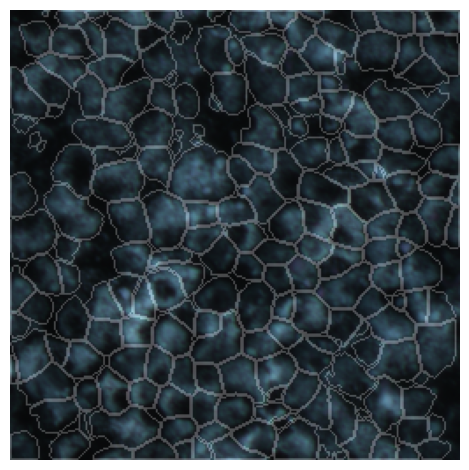

Overlay image saved as 'overlay.png'


In [9]:
image = tifffile.imread('../Demonstration/QBAM_DNNS/Abs Images/AMD1_Clone-B_D75_n719_r1996_c2007.tif')
label = tifffile.imread('../Demonstration/Cell Seg txt/1B_D75_n719.tif')

# Convert image2 to RGBA if it's not
if len(label.shape) == 2:
    label = np.stack((label,)*3, axis=-1)
    label = np.dstack((label, np.full_like(label[:, :, 0], 128)))  # Add alpha channel
else:
    label = np.dstack((label, np.full_like(label[:, :, 0], 128)))  # Add alpha channel

# Normalize image2 to have values between 0 and 1
label = label.astype(float) / 255

# Overlay the images
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(label, alpha=0.5)  # Make image2 semi-transparent

# Save the figure
fig.savefig('overlay.png', dpi=300)

# Display the result
plt.axis('off')
plt.tight_layout()
plt.show()

print("Overlay image saved as 'overlay.png'")

### Change Name for WIPP

In [59]:
folder_path = '../Demonstration/WIPP QBAM_DNNS/Abs Images' 
files = os.listdir(folder_path)

for file_name in files:
    if file_name.endswith('.tif'):
        match = re.match(r"AMD(\d+)_Clone-(\w+)_D(\d+)_n(\d+)", file_name)
        if match:
            new_name = f"{match.group(1)}{match.group(2)}_D{match.group(3)}_n{match.group(4)}.tif"
            old_file = os.path.join(folder_path, file_name)
            new_file = os.path.join(folder_path, new_name)
            os.rename(old_file, new_file)
            # print(f"Renamed: {file_name} -> {new_name}")
        else:
            print(f"Skipped: {file_name} (pattern not matched)")

print("Renaming Images completed.")


folder_path = '../Demonstration/WIPP QBAM_DNNS/Abs Labels' 
files = os.listdir(folder_path)

for file_name in files:
    if file_name.endswith('.tif'):
        match = re.match(r"AMD(\d+)_Clone-(\w+)_D(\d+)_n(\d+)", file_name)
        if match:
            new_name = f"{match.group(1)}{match.group(2)}_D{match.group(3)}_n{match.group(4)}.tif"
            old_file = os.path.join(folder_path, file_name)
            new_file = os.path.join(folder_path, new_name)
            os.rename(old_file, new_file)
            # print(f"Renamed: {file_name} -> {new_name}")
        else:
            print(f"Skipped: {file_name} (pattern not matched)")

print("Renaming Labels completed.")

Renaming Images completed.
Renaming Labels completed.


### Count Matches

In [4]:
# Define your source directories
# image_source_dir = '../Demonstration/WIPP QBAM_DNNS/Abs Images'
# label_source_dir = '../Demonstration/WIPP QBAM_DNNS/Abs Labels'
image_source_dir = '../../Data/Cellpose Segmentations/images'
label_source_dir = '../../Data/Cellpose Segmentations/outlines'

# Get the list of all files in the source directories
image_files = set(os.listdir(image_source_dir))
label_files = set(os.listdir(label_source_dir))

# Find the matches
matches = image_files.intersection(label_files)
# Print the number of matches
print(f'Number of matches: {len(matches)}')

# Find the files that don't match
non_matches = image_files.symmetric_difference(label_files)
# Print the names of the non-matching files
print('Non-matches: ', non_matches)

Number of matches: 1032
Non-matches:  set()


## Analyze CSV

In [13]:
import csv
from statistics import mean, median, stdev

with open('../Demonstration/clean/1B_D75_n719.ome.tif.csv', 'r') as file:
    reader = csv.DictReader(file)    
    area_values = []
    
    for row in reader:
        area_value = float(row['Area'])
        area_values.append(area_value)

    npArea = np.array(area_values)

    avg_area = mean(area_values)
    median_area = median(area_values)
    min_area = min(area_values)
    max_area = max(area_values)
    std_dev_area = stdev(area_values)

    quantiles = np.linspace(0, 1, 9)
    quantile_values = np.quantile(npArea, quantiles)

    print(f"Average of 'Area' column: {avg_area}")
    print(f"Median of 'Area' column: {median_area}")
    print(f"Minimum value in 'Area' column: {min_area}")
    print(f"Maximum value in 'Area' column: {max_area}")
    print(f"Standard deviation of 'Area' column: {std_dev_area}")
    print("Below are 9 'Area' quantiles:")
    print("q1:", quantile_values[0],
          "q2:", quantile_values[1],
          "q3:", quantile_values[2],
          "q4:", quantile_values[3],
          "q5:", quantile_values[4],
          "q6:", quantile_values[5],
          "q7:", quantile_values[6],
          "q8:", quantile_values[7],
          "q9:", quantile_values[8])


Average of 'Area' column: 280.45652173913044
Median of 'Area' column: 261.5
Minimum value in 'Area' column: 151.0
Maximum value in 'Area' column: 479.0
Standard deviation of 'Area' column: 83.81793961290195
Below are 9 'Area' quantiles:
q1: 151.0 q2: 186.25 q3: 208.5 q4: 237.375 q5: 261.5 q6: 300.25 q7: 340.5 q8: 394.75 q9: 479.0


## GNN Data Gen

### Remove NaN from csv

In [12]:
folder_path = '../Demonstration/csv'

out_path = '../Demonstration/clean'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        df = pd.read_csv(f'{folder_path}/{file_name}')
        before = len(df)
        print("Length Before: ", before)

        df_cleaned = df.dropna()
        df_cleaned = df_cleaned[df_cleaned['Area'] < 500]  
        df_cleaned = df_cleaned[df_cleaned['Area'] > 150]

        
        df_cleaned.to_csv(f'{out_path}' + '/' + f'{file_name}', index=False)

        after = len(df_cleaned)
        print("Length After: ", after)


        print(f"Removed {before - after} Rows with NaN or outlier values.")

# input_path = 'Dataset'

# for folder in os.listdir(input_path):

#     folder_path = input_path + '/' + folder + '/Test'
#     out_path = input_path + '/' + folder + '/cleaned test'

#     for file_name in os.listdir(folder_path):
#         if file_name.endswith('.csv'):
#             df = pd.read_csv(f'{folder_path}/{file_name}')
#             before = len(df)
#             print("Length Before: ", before)

#             df_cleaned = df.dropna()
#             df_cleaned = df_cleaned[df_cleaned['Area'] < 500]  
#             df_cleaned = df_cleaned[df_cleaned['Area'] > 150]

            
#             df_cleaned.to_csv(f'{out_path}' + '/' + f'{file_name}', index=False)

#             after = len(df_cleaned)
#             print("Length After: ", after)


#             print(f"Removed {before - after} Rows with NaN or outlier values.")

Length Before:  479
Length After:  138
Removed 341 Rows with NaN or outlier values.


### Get Features Array

In [25]:
def get_features(centroid_data):

    features = centroid_data[['Area', 'Aspect_Ratio_BB', 'BB_Xmin', 'BB_Ymin', 'BB_Width', 'BB_Height', 
                              'Center_BB_X', 'Center_BB_Y', 'Centroid_X', 'Centroid_Y', 'Circularity', 
                              'Distance_From_Border', 'Eccentricity', 'Entropy', 'ExtendBB', 'Mean', 
                              'Median', 'Mode', 'Orientation', 'Perimeter', 'StandardDeviation', 
                              'Skewness', 'Kurtosis', 'Hyperskewness', 'Hyperflatness', 'TContrast_Average', 
                              'TContrast_Ortho_principal_component_value', 'TContrast_Principal_component_angle', 
                              'TContrast_Principal_component_value', 'TCorrelation_Average', 
                              'TCorrelation_Ortho_principal_component_value', 'TCorrelation_Principal_component_angle', 
                              'TCorrelation_Principal_component_value', 'THomogeneity_Average', 
                              'THomogeneity_Ortho_principal_component_value', 'THomogeneity_Principal_component_angle', 
                              'THomogeneity_Principal_component_value', 'TEnergy_Average', 
                              'TEnergy_Ortho_principal_component_value', 'TEnergy_Principal_component_angle', 
                              'TEnergy_Principal_component_value', 'TVariance_Average', 
                              'TVariance_Ortho_principal_component_value', 'TVariance_Principal_component_angle', 
                              'TVariance_Principal_component_value', 'TEntropy_Average', 
                              'TEntropy_Ortho_principal_component_value', 'TEntropy_Principal_component_angle', 
                              'TEntropy_Principal_component_value', 'TInvDiffMoment_Average', 
                              'TInvDiffMoment_Ortho_principal_component_value', 'TInvDiffMoment_Principal_component_angle', 
                              'TInvDiffMoment_Principal_component_value', 'TSumAverage_Average', 
                              'TSumAverage_Ortho_principal_component_value', 'TSumAverage_Principal_component_angle', 
                              'TSumAverage_Principal_component_value', 'TSumVariance_Average', 
                              'TSumVariance_Ortho_principal_component_value', 'TSumVariance_Principal_component_angle', 
                              'TSumVariance_Principal_component_value', 'TSumEntropy_Average', 
                              'TSumEntropy_Ortho_principal_component_value', 'TSumEntropy_Principal_component_angle', 
                              'TSumEntropy_Principal_component_value', 'TDiffAverage_Average', 
                              'TDiffAverage_Ortho_principal_component_value', 'TDiffAverage_Principal_component_angle', 
                              'TDiffAverage_Principal_component_value', 'TDiffVariance_Average', 
                              'TDiffVariance_Ortho_principal_component_value', 'TDiffVariance_Principal_component_angle', 
                              'TDiffVariance_Principal_component_value', 'TDiffEntropy_Average', 
                              'TDiffEntropy_Ortho_principal_component_value', 'TDiffEntropy_Principal_component_angle', 
                              'TDiffEntropy_Principal_component_value'

                              ]].values.astype(np.float32)

    return features

### Generate Graphs

In [76]:
import os
import pandas as pd

dfs = {}

for dtype in ["TER", "VEGF"]:
    df_y = pd.read_csv(f'GNN Label CSVs/AMD_{dtype}_Data.csv')
    dfs[dtype] = df_y

for df_key in dfs:
    df = dfs[df_key]
    df['Title'] = df.apply(lambda row: f"{row['clone']}{row['day']}", axis=1)
    dfs[df_key] = df

def extract_clone_day_from_filename(filename):
    basename = os.path.basename(filename)
    parts = basename.split('_')
    clone = parts[0]  # Example: '1A'
    day = parts[1][1:]    # Example: 'D75'
    return clone, day

bin_count = {}

scanned = 0
for split in ["Train", "Test", "Valid"]:
    centroids_filepath = f'../../Data/CellPose Segmentations/clean/{split}'
    for file in os.listdir(centroids_filepath):
        scanned += 1
        if file.endswith('.csv'):
            clone, day = extract_clone_day_from_filename(file)
            title = f"{clone}{day}"
            if title in bin_count:
                bin_count[title] += 1
            else:
                bin_count[title] = 1
        # else: print(f"Non-match: {file}")


sum_bin_files = 0
for key in bin_count:
    print(f"Bin Name: {key}, Count: {bin_count[key]}")
    sum_bin_files += bin_count[key]

print(f"Scanned {scanned}, Found {sum_bin_files} bins")

for df_key in dfs:
    df = dfs[df_key]
    label_bins = df["Title"].unique()
    # print(f"Label Bins: {label_bins}")
    for bin in label_bins:
        if df_key == "VEGF": bin = bin[0:2] + bin[3:]
        if bin not in bin_count:
            print(f"{df_key} Label Bin {bin} missing from files")
        

Bin Name: 1B74, Count: 86
Bin Name: 3B73, Count: 149
Bin Name: 3B74, Count: 144
Bin Name: 1B75, Count: 94
Bin Name: 1A75, Count: 109
Bin Name: 3C75, Count: 151
Bin Name: 1B76, Count: 161
Bin Name: 1B73, Count: 1
Bin Name: 2B73, Count: 64
Bin Name: 1B77, Count: 71
Scanned 1033, Found 1030 bins
TER Label Bin 2A75 missing from files
TER Label Bin 2B74 missing from files
TER Label Bin 2B75 missing from files
TER Label Bin 2B76 missing from files
TER Label Bin 2B77 missing from files
TER Label Bin 2C75 missing from files
TER Label Bin 3A75 missing from files
TER Label Bin 3B75 missing from files
TER Label Bin 3B76 missing from files
TER Label Bin 3B77 missing from files
VEGF Label Bin 2A75 missing from files
VEGF Label Bin 2B75 missing from files
VEGF Label Bin 2B77 missing from files
VEGF Label Bin 2C75 missing from files
VEGF Label Bin 3A75 missing from files
VEGF Label Bin 3B75 missing from files
VEGF Label Bin 3B77 missing from files


In [81]:
dfs["VEGF"]['Title']

0     1AD75
1     1BD73
2     1BD75
3     1BD77
4     2AD75
5     2BD73
6     2BD75
7     2BD77
8     2CD75
9     3AD75
10    3BD73
11    3BD75
12    3BD77
13    3CD75
Name: Title, dtype: object

In [98]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
from scipy.spatial.distance import cdist
import pickle

# data_type = "TER"
# data_type = "VEGF"
data_type = "Both"
# data_type = "Donor"

# split="Train"
split="Valid"
# split="Test"

normalize = True
norm_string = "_normalized" if normalize else ""

if data_type != "Donor":
    dtype_list = ["TER", "VEGF"] if data_type == "Both" else [f"{data_type}"]

centroids_filepath = f'../../Data/CellPose Segmentations/clean/{split}'
output_filename = f'{split}_{data_type}{norm_string}.pkl'


if data_type != "Donor":
    dfs = {}

    for dtype in dtype_list:
        df_y = pd.read_csv(f'GNN Label CSVs/AMD_{dtype}_Data.csv')
        dfs[dtype] = df_y

    for df_key in dfs:
        df = dfs[df_key]
        df['Title'] = df.apply(lambda row: f"{row['clone']}{row['day']}", axis=1)
        dfs[df_key] = df

num_neighbours = 20

data_list = []

def extract_clone_day_from_filename(filename):
    basename = os.path.basename(filename)
    parts = basename.split('_')
    clone = parts[0]  # Example: '1A'
    day = parts[1][1:]    # Example: 'D75'
    return clone, day

count = 0
not_added = 0

for file in os.listdir(centroids_filepath):
    if file.endswith('.csv'):
        file_path = os.path.join(centroids_filepath, file)
        # print("Processing file:", file)

        centroids = pd.read_csv(file_path)

        clone, day = extract_clone_day_from_filename(file)
        
        if data_type != "Donor":
            if "TER" in dtype_list:
                match_title = f"{clone}{day}"
                cur_df = dfs["TER"]
                matched_TER_row = cur_df[cur_df['Title'] == match_title]

                if matched_TER_row.empty:
                    print(f"No matching TER value found for title: {match_title}")
                    not_added +=1
                    continue
                
                matched_TER = matched_TER_row['ter.Mean'].iloc[0]
                if normalize: matched_TER /= 1000
            
            if "VEGF" in dtype_list:
                match_title = f"{clone}D{day}"
                cur_df = dfs["VEGF"]
                matched_VEGF_row = cur_df[cur_df['Title'] == match_title]
                
                if matched_VEGF_row.empty:
                    print(f"No matching VEGF value found for title: {match_title}")
                    not_added +=1
                    continue

                if normalize: 
                    matched_VEGF = matched_VEGF_row['ratio.Mean'].iloc[0]
                    matched_VEGF /= 10
                else:
                    matched_VEGF_numerator = matched_VEGF_row['Basal_pg.ml.Mean'].iloc[0]
                    matched_VEGF_denominator = matched_VEGF_row['Apical_pg.ml.Mean'].iloc[0]

        if 'Partition_ID' in centroids.columns:
            centroids = centroids.drop('Partition_ID', axis=1)

        features = get_features(centroids)

        sp_centroids = centroids[['Centroid_X', 'Centroid_Y']].values
        num_nodes = len(sp_centroids)
        euc_distances = cdist(sp_centroids, sp_centroids)
        closest_neighbours = np.argsort(euc_distances, axis=1)[:, :num_neighbours + 1]
        edge_array = np.array([np.repeat(range(num_nodes), num_neighbours + 1), np.reshape(closest_neighbours, (-1))])
        edge_index = torch.tensor(edge_array, dtype=torch.long)

        closest_distances = np.sort(euc_distances, axis=1)[:, :num_neighbours + 1]
        edge_weights = np.exp(-np.reshape(closest_distances, (-1)))
        edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

        edge_index, edge_weights = torch_geometric.utils.to_undirected(edge_index, edge_weights)

        data = Data(x=torch.tensor(features, dtype=torch.float), edge_index=edge_index, edge_weights=edge_weights)

        output_list = []
        if data_type == "Donor":
            one_hot = [0,0,0]
            one_hot[int(clone[0]) - 1] = 1
            output_list = one_hot
        else:
            if "VEGF" in dtype_list:
                if normalize: output_list += [matched_VEGF]
                else: output_list += [matched_VEGF_numerator, matched_VEGF_denominator]
            if "TER" in dtype_list:
                output_list.append(matched_TER)

        data.y = torch.tensor(output_list, dtype=torch.float)
        count += 1
        data_list.append(data)
print("added ", count)
print("Couldnt add", not_added)

print(data_list)

with open(output_filename, 'wb') as f:
    pickle.dump(data_list, f)

print("Dataset construction completed. Data saved to:", output_filename)



added  71
Couldnt add 0
[Data(x=[157, 77], edge_index=[2, 3727], edge_weights=[3727], y=[2]), Data(x=[123, 77], edge_index=[2, 2981], edge_weights=[2981], y=[2]), Data(x=[115, 77], edge_index=[2, 2747], edge_weights=[2747], y=[2]), Data(x=[147, 77], edge_index=[2, 3519], edge_weights=[3519], y=[2]), Data(x=[151, 77], edge_index=[2, 3603], edge_weights=[3603], y=[2]), Data(x=[148, 77], edge_index=[2, 3580], edge_weights=[3580], y=[2]), Data(x=[128, 77], edge_index=[2, 3148], edge_weights=[3148], y=[2]), Data(x=[136, 77], edge_index=[2, 3286], edge_weights=[3286], y=[2]), Data(x=[147, 77], edge_index=[2, 3521], edge_weights=[3521], y=[2]), Data(x=[142, 77], edge_index=[2, 3414], edge_weights=[3414], y=[2]), Data(x=[149, 77], edge_index=[2, 3567], edge_weights=[3567], y=[2]), Data(x=[143, 77], edge_index=[2, 3397], edge_weights=[3397], y=[2]), Data(x=[137, 77], edge_index=[2, 3287], edge_weights=[3287], y=[2]), Data(x=[154, 77], edge_index=[2, 3680], edge_weights=[3680], y=[2]), Data(x=[1

### Dataset Details

In [49]:
df2 = pd.read_pickle('Test_Donor_check.pkl')

print(f'Number of graphs: {len(df2)}')
print(f'Number of features: {df2[0].num_features}')

for dataset in df2:
  print('----------------------')
  print(f'Data: {dataset}:')
  print('----------------------')
  # Gather some statistics about the first graph.
  print(f'Number of nodes: {dataset.num_nodes}')
  print(f'Number of edges: {dataset.num_edges}')
  print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
  print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
  print(f'Has self-loops: {dataset.has_self_loops()}')
  print(f'Is undirected: {dataset.is_undirected()}')
  print()
  print("=====================================")

Number of graphs: 151
Number of features: 77
----------------------
Data: Data(x=[156, 77], edge_index=[2, 3712], edge_weights=[3712], y=[3]):
----------------------
Number of nodes: 156
Number of edges: 3712
Average node degree: 23.79
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[162, 77], edge_index=[2, 3848], edge_weights=[3848], y=[3]):
----------------------
Number of nodes: 162
Number of edges: 3848
Average node degree: 23.75
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[170, 77], edge_index=[2, 4026], edge_weights=[4026], y=[3]):
----------------------
Number of nodes: 170
Number of edges: 4026
Average node degree: 23.68
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[163, 77], edge_index=[2, 3887], edge_weights=[3887], y=[3]):
----------------------
Number of nodes: 163
Number of edges: 3887
Average node d